In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os

gpus = len(tf.config.list_physical_devices('GPU'))
assert gpus > 0

In [2]:
data_dir = '../data/dogs_vs_cats'
print(os.listdir(data_dir))

['test1', 'train', 'sampleSubmission.csv']


In [3]:
IMG_SIZE = 224
BATCH_SIZE = 64

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir + '/train',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=BATCH_SIZE)

valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir + '/train',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=BATCH_SIZE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)

['cat', 'dog']


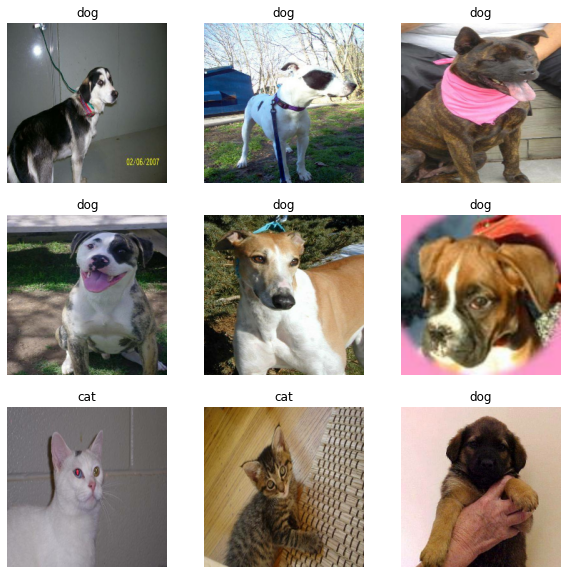

In [6]:
# def format_label(label):
#     string_label = label_info.int2str(label)
#     return string_label.split("-")[1]

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(64, 224, 224, 3)
(64,)


In [8]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers

def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = inputs
    model = EfficientNetB0(include_top=False, input_tensor=x, weights='imagenet')
    model.trainable = False
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)
    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model


In [9]:
model = build_model(len(class_names))
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [11]:
epochs = 5
hist = model.fit(train_ds, epochs=epochs, validation_data=valid_ds, verbose=2)

Epoch 1/5
313/313 - 115s - loss: 0.1290 - accuracy: 0.9850 - val_loss: 0.1263 - val_accuracy: 0.9886
Epoch 2/5
313/313 - 115s - loss: 0.1294 - accuracy: 0.9848 - val_loss: 0.1215 - val_accuracy: 0.9892
Epoch 3/5
313/313 - 114s - loss: 0.1446 - accuracy: 0.9840 - val_loss: 0.1109 - val_accuracy: 0.9916
Epoch 4/5
313/313 - 114s - loss: 0.1412 - accuracy: 0.9855 - val_loss: 0.1071 - val_accuracy: 0.9902
Epoch 5/5
313/313 - 115s - loss: 0.1232 - accuracy: 0.9848 - val_loss: 0.1285 - val_accuracy: 0.9874


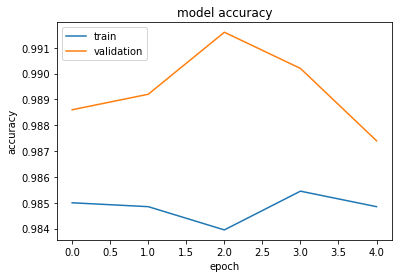

In [12]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_hist(hist)

In [13]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )

unfreeze_model(model)

Epoch 1/5
313/313 - 132s - loss: 0.0916 - accuracy: 0.9880 - val_loss: 0.1011 - val_accuracy: 0.9890
Epoch 2/5
313/313 - 115s - loss: 0.0636 - accuracy: 0.9900 - val_loss: 0.1177 - val_accuracy: 0.9884
Epoch 3/5
313/313 - 113s - loss: 0.0431 - accuracy: 0.9926 - val_loss: 0.1173 - val_accuracy: 0.9886
Epoch 4/5
313/313 - 116s - loss: 0.0345 - accuracy: 0.9938 - val_loss: 0.0995 - val_accuracy: 0.9914
Epoch 5/5
313/313 - 116s - loss: 0.0319 - accuracy: 0.9944 - val_loss: 0.0981 - val_accuracy: 0.9904


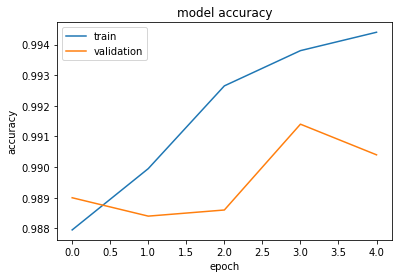

In [14]:
epochs = 5
hist = model.fit(train_ds, epochs=epochs, validation_data=valid_ds, verbose=2)
plot_hist(hist)

In [21]:
test_filenames = os.listdir(data_dir + '/test1')
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]
print(nb_samples)
test_df.head()

12500


,filename
0,11921.jpg
1,3114.jpg
2,7682.jpg
3,10754.jpg
4,6865.jpg


In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


test_gen = ImageDataGenerator()
test_generator = test_gen.flow_from_dataframe(
    test_df,
    data_dir + '/test1',
    x_col='filename',
    y_col=None,
    class_mode=None,
    batch_size=BATCH_SIZE,
    target_size=(IMG_SIZE, IMG_SIZE),
    shuffle=False,
)

Found 12500 validated image filenames.


In [23]:
predictions = model.predict(test_generator)

In [29]:
test_df['category'] = np.argmax(predictions, axis=-1)

In [30]:
test_df.head()

,filename,category
0,11921.jpg,1
1,3114.jpg,1
2,7682.jpg,0
3,10754.jpg,0
4,6865.jpg,0


In [31]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)